<a href="https://colab.research.google.com/github/carlosperez1997/flight_delay_prediction/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install psutil
!pip install humanize

In [2]:
import os, humanize, psutil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

In [3]:
mem_report()

CPU RAM Free: 12.6 GB


In [4]:
def date_features(df, col):
    df[col] = pd.to_datetime(df[col])
    df['month'] = df[col].dt.month
    df['day'] = df[col].dt.day
    df['year'] = df[col].dt.year
    df['FL_DATE_quarter'] = df['FL_DATE'].dt.quarter
    df['weekday'] = df[col].dt.weekday
    df['year_month'] = [ str(y)+'_'+str(m) if m < 10 else str(y)+'_0'+str(m) for y, m in zip(df['year'], df['month']) ]
    df['year_week'] = df[col].dt.strftime('%Y%V')

    return df

In [5]:
# Add flight distance in km
def flight_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = lat1 * math.pi/180
    phi2 = lat2 * math.pi/180
    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180
    
    a = np.sin(delta_phi/2) * np.sin(delta_lambda/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2);
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return np.round(R * c) # in kilometres

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        try:
            if col_type != object:
                
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        except:
            pass
            
    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Basics
import pandas as pd
import numpy as np
import time
import os
from os import listdir
from os.path import isfile, join, basename
from tqdm import tqdm
from timeit import timeit
import gc
from sys import getsizeof

import math
import sys
import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
DIR = '/Users/carlosperezricardo/Desktop/TFM'
DIR = '/content/drive/MyDrive/TFM'

AIRPORT = 10397
years_to_load = ['2017','2018','2019']

In [10]:
folder = os.path.join(DIR, 'datasets')
files = [f for f in listdir(folder) if isfile(join(folder, f))]
files = sorted(files)

In [11]:
if os.path.exists(os.path.join(DIR, 'df_all.pkl')):
    df = pd.read_pickle(os.path.join(DIR, 'df_all.pkl'))
else:
    df = pd.DataFrame()
    for file in files:
        loading = []
        if '.zip' in file:
            for year in years_to_load:
                loading.append(year in file)
            output = any(loading)
            if output:
                add_df = pd.read_csv(os.path.join(DIR,'datasets',file), parse_dates=['FL_DATE'])
                add_df = pd.read_csv(os.path.join(DIR,'datasets',file))
                add_df = reduce_mem_usage(add_df)
                df = pd.concat([df, add_df], axis=0)
                del add_df
    df.reset_index(drop=True, inplace=True)
    del df['Unnamed: 29']
    df.to_pickle(os.path.join(DIR, 'df_all.pkl'))

In [12]:
df.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
0,2017-01-01,AA,19805,AA,N3GNAA,2186,14100,1410002,34100,PHL,...,-5.0,731.0,-19.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
1,2017-01-01,AA,19805,AA,N3KAAA,2189,11298,1129804,30194,DFW,...,2.0,2023.0,-4.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2,2017-01-01,AA,19805,AA,N3LFAA,2190,11298,1129804,30194,DFW,...,0.0,4.0,16.0,0.0,NaN,0.0,0.0,0.0,16.0,0.0
3,2017-01-01,AA,19805,AA,N3DDAA,2191,11697,1169704,32467,FLL,...,-2.0,1528.0,-10.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
4,2017-01-01,AA,19805,AA,N3HLAA,2192,11278,1127803,30852,DCA,...,2.0,2052.0,12.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN


In [13]:
df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [14]:
df = date_features(df, 'FL_DATE')

In [15]:
df = reduce_mem_usage(df)

# Univariate Analysis

## Time variables

In [16]:
df = df[(df.DEP_DELAY.isnull() == False) & (df.ARR_DELAY.isnull() == False)]

In [17]:
df['DEP_TIME_hour'] = round(df['DEP_TIME']/100).astype(int)
df['ARR_TIME_hour'] = round(df['ARR_TIME']/100).astype(int)

In [18]:
time_vars = ['FL_DATE','month','day','year','FL_DATE_quarter','weekday','year_month','year_week','DEP_TIME_hour','ARR_TIME_hour']

In [19]:
for col in time_vars:
    df[col] = df[col].astype('category')

df[time_vars].describe()

,FL_DATE,month,day,year,FL_DATE_quarter,weekday,year_month,year_week,DEP_TIME_hour,ARR_TIME_hour
count,19919460,19919460,19919460,19919460,19919460,19919460,19919460,19919460,19919460,19919460
unique,1095,12,31,3,4,7,36,156,25,25
top,2019-08-05 00:00:00,7,26,2019,3,4,2019_8,201901,6,16
freq,22278,1776747,666850,7268232,5163166,2973017,645351,150528,1373993,1237816


## Numerical variables

In [20]:
numerical_vars = ['DEP_DELAY','ARR_DELAY','CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']

In [21]:
desc = pd.DataFrame()
for col in numerical_vars:
    #df[col].fillna(0, inplace=True)
    x = df.loc[df[col].isnull() == False, col]
    y = x.describe().astype('float16')
    y['count'] = len(x)/10000
    y['mean'] = x.astype(int).mean()
    y['std'] = x.astype(int).std()

    desc = pd.concat([desc, y], axis=1)

In [22]:
desc

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
count,1992.000000,1992.000000,377.000000,377.000000,377.00000,377.000000
mean,10.179688,4.984375,20.203125,3.447266,16.18750,26.171875
std,45.937500,48.187500,62.562500,29.500000,37.34375,50.625000
min,-234.000000,-238.000000,0.000000,0.000000,0.00000,0.000000
25%,-5.000000,-15.000000,0.000000,0.000000,0.00000,0.000000
50%,-2.000000,-6.000000,0.000000,0.000000,2.00000,3.000000
75%,7.000000,7.000000,17.000000,0.000000,20.00000,32.000000
max,2710.000000,2696.000000,2696.000000,2692.000000,1848.00000,2454.000000


In [23]:
desc.astype(int)

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
count,1992,1992,377,377,377,377
mean,10,4,20,3,16,26
std,45,48,62,29,37,50
min,-234,-238,0,0,0,0
25%,-5,-15,0,0,0,0
50%,-2,-6,0,0,2,3
75%,7,7,17,0,20,32
max,2710,2696,2696,2692,1848,2454


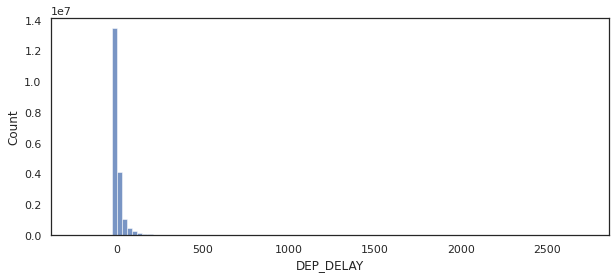

In [24]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

sns.histplot(data=df, x='DEP_DELAY', bins=100)
plt.show()

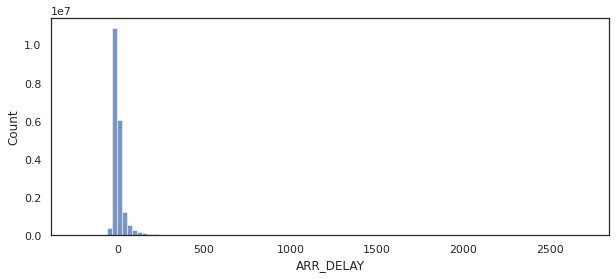

In [25]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

sns.histplot(data=df, x='ARR_DELAY', bins=100)
plt.show()

## Categorical variables

In [26]:
carrier_vars = ['OP_UNIQUE_CARRIER','OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM','OP_CARRIER_FL_NUM']
origin_vars = ['ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','ORIGIN_CITY_MARKET_ID','ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_ABR']
dest_vars = ['DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','DEST_CITY_MARKET_ID','DEST','DEST_CITY_NAME','DEST_STATE_ABR']

In [27]:
for col in carrier_vars + origin_vars + dest_vars:
    df[col] = df[col].astype('category')

In [28]:
df[carrier_vars].describe()

,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM
count,19919460,19919460,19919460,19919460,19919460
unique,18,18,18,7200,7167
top,WN,19393,WN,N483HA,511
freq,3968160,3968160,3968160,10210,9907


In [29]:
df[origin_vars].describe()

,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR
count,19919460,19919460,19919460,19919460,19919460,19919460
unique,364,635,338,364,356,52
top,10397,1039707,31703,ATL,"Chicago, IL",CA
freq,1135900,804128,1193649,1135900,1166071,2327693


In [30]:
df[dest_vars].describe()

,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR
count,19919460,19919460,19919460,19919460,19919460,19919460
unique,365,636,339,365,357,52
top,10397,1039707,31703,ATL,"Chicago, IL",CA
freq,1135936,804433,1191420,1135936,1164209,2328769


# Multivariate Analysis

## DEST

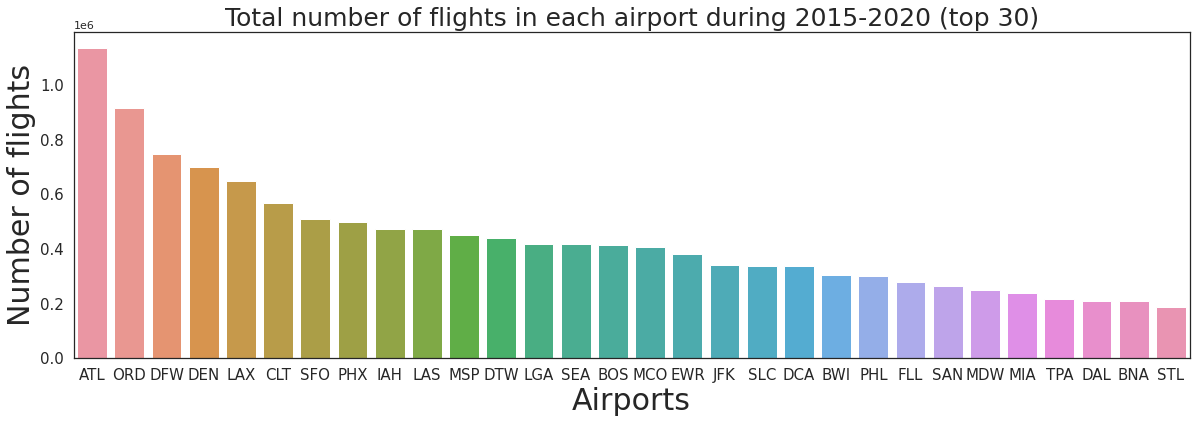

In [31]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(20,6))

dest_vc = df['DEST'].value_counts().to_frame()
dest_vc = dest_vc.sort_values('DEST',ascending=False)
dest_vc.reset_index(inplace=True)
dest_vc['index'] = dest_vc['index'].astype('string')
dest_vc = dest_vc.head(30)

ax = sns.barplot(x="index", y="DEST", data=dest_vc)
ax.axes.set_title("Total number of flights in each airport during 2015-2020 (top 30)",fontsize=25)
ax.set_xlabel("Airports",fontsize=30)
ax.set_ylabel("Number of flights",fontsize=30)
ax.tick_params(labelsize=15)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


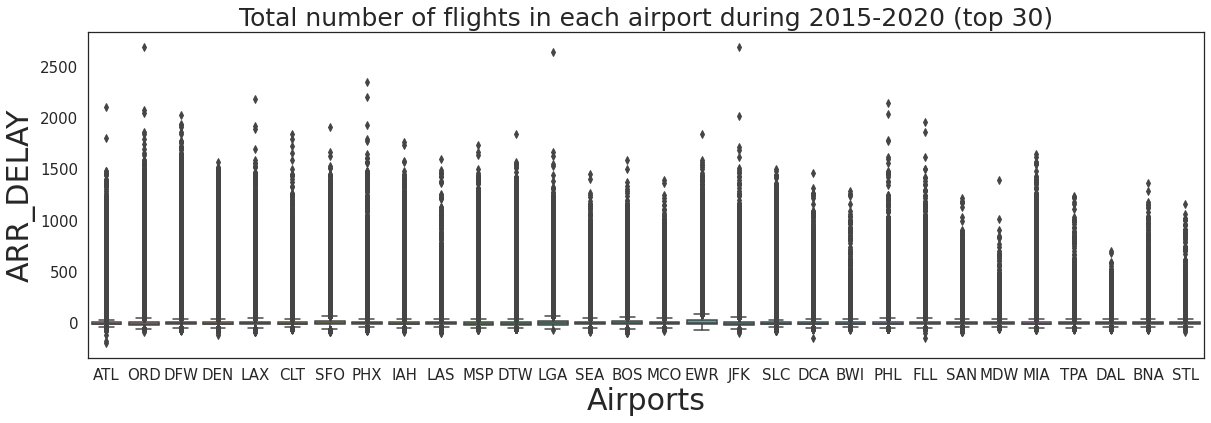

In [32]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(20,6))

dest_map = {k:v for k,v in zip(dest_vc['index'], range(len(dest_vc.index)))}

dest_delay = df[df.DEST.isin(dest_vc['index'].to_list())]
dest_delay['DEST'] = dest_delay['DEST'].astype('string')
dest_delay['idx'] =  dest_delay['DEST'].map(dest_map)
dest_delay = dest_delay.sort_values('idx')

ax2_ = sns.boxplot(x="DEST", y="ARR_DELAY", data=dest_delay)
ax2_.axes.set_title("Total number of flights in each airport during 2015-2020 (top 30)",fontsize=25)
ax2_.set_xlabel("Airports",fontsize=30)
ax2_.set_ylabel("ARR_DELAY",fontsize=30)
ax2_.tick_params(labelsize=15)

del dest_vc

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


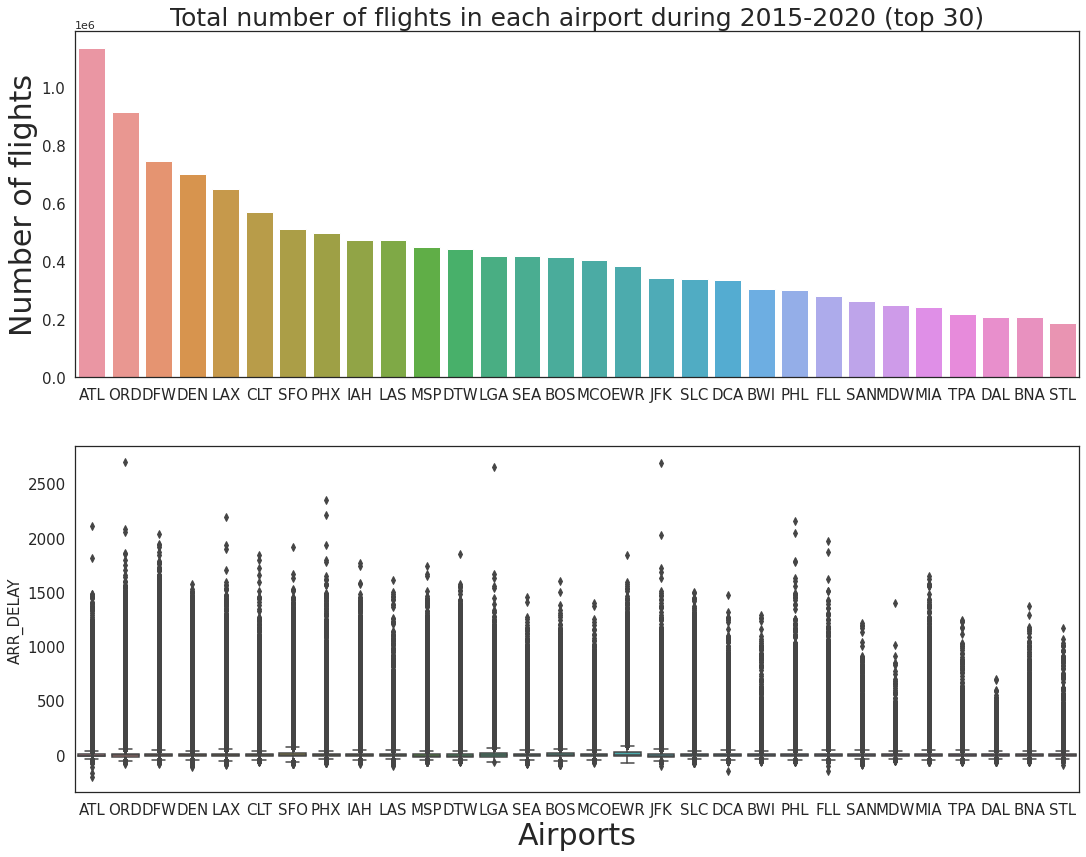

In [33]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

dest_vc = df['DEST'].value_counts().to_frame()
dest_vc = dest_vc.sort_values('DEST',ascending=False)
dest_vc.reset_index(inplace=True)
dest_vc['index'] = dest_vc['index'].astype('string')
dest_vc = dest_vc.head(30)

sns.barplot(x="index", y="DEST", data=dest_vc, ax=ax1)
ax1.axes.set_title("Total number of flights in each airport during 2015-2020 (top 30)",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=30)
ax1.tick_params(labelsize=15)

dest_map = {k:v for k,v in zip(dest_vc['index'], range(len(dest_vc.index)))}

dest_delay = df[df.DEST.isin(dest_vc['index'].to_list())]
dest_delay['DEST'] = dest_delay['DEST'].astype('string')
dest_delay['idx'] =  dest_delay['DEST'].map(dest_map)
dest_delay = dest_delay.sort_values('idx')

sns.boxplot(x="DEST", y="ARR_DELAY", data=dest_delay, ax=ax2)
ax2.set_xlabel("Airports",fontsize=30)
ax2.set_ylabel("ARR_DELAY",fontsize=15)
ax2.tick_params(labelsize=15)

plt.show()

In [34]:
del dest_vc, dest_delay, fig, ax1, ax2
gc.collect()

55

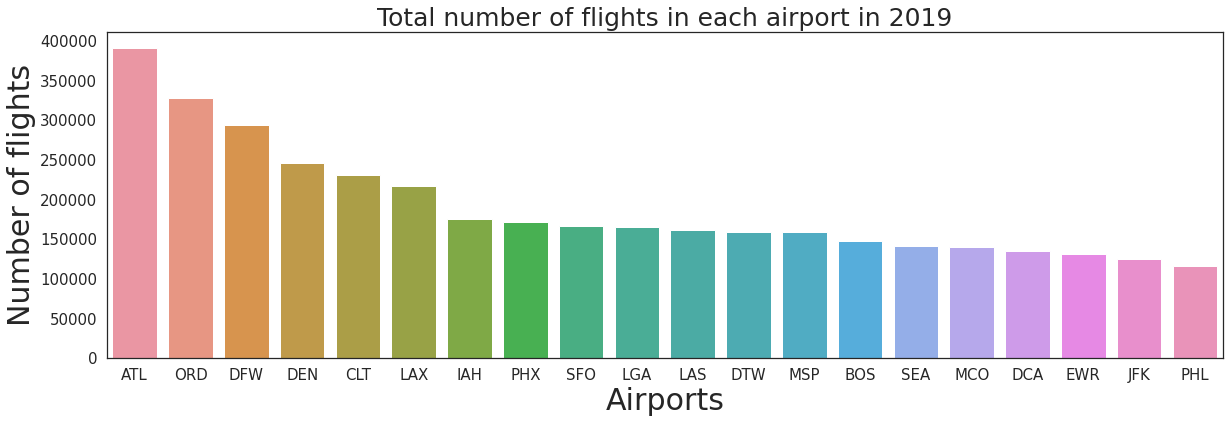

In [35]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(20,6))

dest_vc = df[df.year == 2019]['DEST'].value_counts().to_frame()
dest_vc = dest_vc.sort_values('DEST',ascending=False)
dest_vc.reset_index(inplace=True)
dest_vc['index'] = dest_vc['index'].astype('string')

ax = sns.barplot(x="index", y="DEST", data=dest_vc.head(20))
ax.axes.set_title("Total number of flights in each airport in 2019",fontsize=25)
ax.set_xlabel("Airports",fontsize=30)
ax.set_ylabel("Number of flights",fontsize=30)
ax.tick_params(labelsize=15)

del dest_vc

plt.show()

## Airline

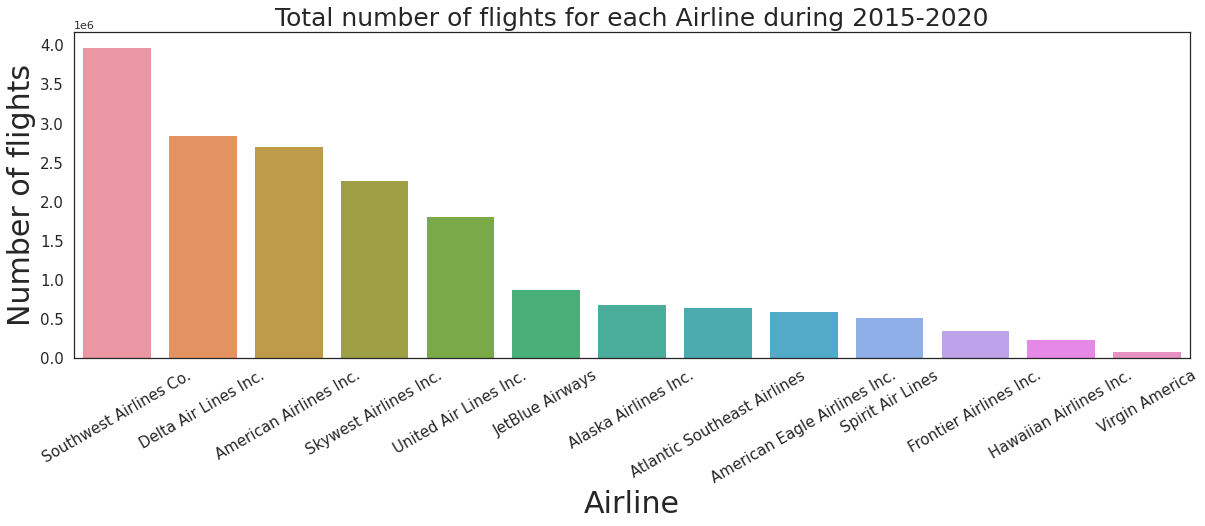

In [36]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(20,6))

airlines = pd.read_csv(os.path.join(DIR, 'airlines_airports', 'airlines.csv'))

carrier_vc = df['OP_UNIQUE_CARRIER'].value_counts().to_frame()
carrier_vc = carrier_vc.sort_values('OP_UNIQUE_CARRIER',ascending=False)
carrier_vc.reset_index(inplace=True)
carrier_vc = pd.merge(carrier_vc, airlines, how='left', left_on='index', right_on='IATA_CODE')

ax = sns.barplot(x="AIRLINE", y="OP_UNIQUE_CARRIER", data=carrier_vc.head(20))
ax.axes.set_title("Total number of flights for each Airline during 2015-2020",fontsize=25)
ax.set_xlabel("Airline",fontsize=30)
ax.set_ylabel("Number of flights",fontsize=30)
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

del carrier_vc, airlines

plt.show()

In [37]:
gc.collect()

38896

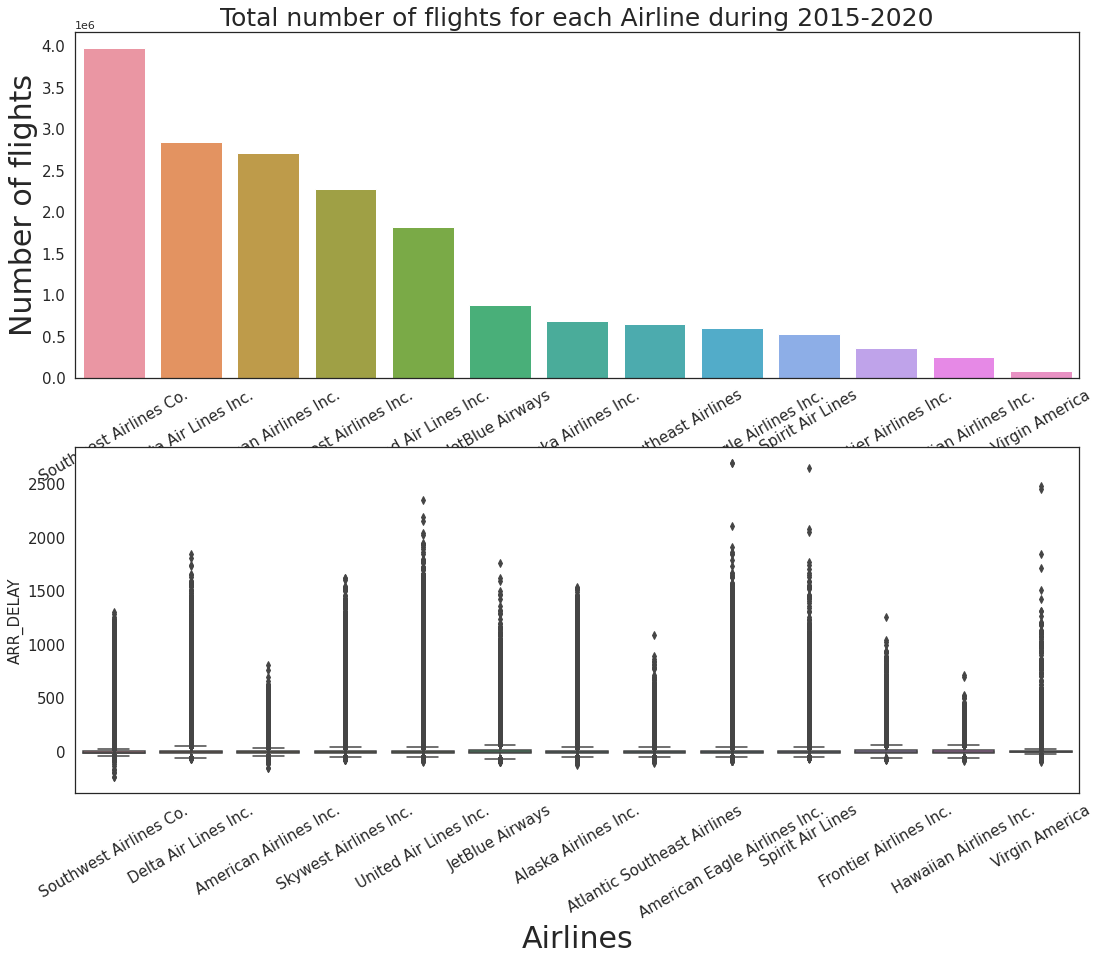

In [38]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

airlines = pd.read_csv(os.path.join(DIR, 'airlines_airports', 'airlines.csv'))

fig, (ax1, ax2) = plt.subplots(nrows=2)

carrier_vc = df['OP_UNIQUE_CARRIER'].value_counts().to_frame()
carrier_vc = carrier_vc.sort_values('OP_UNIQUE_CARRIER',ascending=False)
carrier_vc.reset_index(inplace=True)
carrier_vc['index'] = carrier_vc['index'].astype('string')
carrier_vc = carrier_vc.head(30)

carrier_vc = pd.merge(carrier_vc, airlines, how='left', left_on='index', right_on='IATA_CODE')

sns.barplot(x="AIRLINE", y="OP_UNIQUE_CARRIER", data=carrier_vc, ax=ax1)
ax1.axes.set_title("Total number of flights for each Airline during 2015-2020",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=30)
ax1.tick_params(labelsize=15)
ax1.set_xticklabels(ax.get_xticklabels(),rotation = 30)

carrier_map = {k:v for k,v in zip(carrier_vc['index'], range(len(carrier_vc.index)))}

carrier_delay = df[df.OP_UNIQUE_CARRIER.isin(carrier_vc['index'].to_list())]
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')
carrier_delay['idx'] =  carrier_delay['DEST'].map(dest_map)
carrier_delay = carrier_delay.sort_values('idx')

carrier_delay = pd.merge(carrier_delay, airlines, how='left', left_on='OP_UNIQUE_CARRIER', right_on='IATA_CODE')

sns.boxplot(x="AIRLINE", y="ARR_DELAY", data=carrier_delay, ax=ax2)
ax2.set_xlabel("Airlines",fontsize=30)
ax2.set_ylabel("ARR_DELAY",fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_xticklabels(ax.get_xticklabels(),rotation = 30)

plt.show()

In [39]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
df['ARR_DELAY'] = df['ARR_DELAY'].astype(int)
df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].describe(include = np.number, percentiles = perc).sort_values('count', ascending=False)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
OP_UNIQUE_CARRIER,,,,,,,,,,,,
WN,3968160.0,4.043656,31.629952,-151.0,-22.0,-18.0,-12.0,-4.0,8.0,32.0,58.0,809.0
DL,2844654.0,0.291753,45.100935,-238.0,-28.0,-24.0,-16.0,-9.0,2.0,24.0,54.0,1304.0
AA,2705987.0,5.440244,48.618508,-94.0,-27.0,-22.0,-14.0,-5.0,9.0,38.0,73.0,2350.0
OO,2270649.0,7.106454,61.722031,-91.0,-27.0,-22.0,-15.0,-7.0,7.0,42.0,86.0,2696.0
UA,1810834.0,5.343592,51.780065,-120.0,-28.0,-23.0,-16.0,-7.0,7.0,42.0,83.0,1539.0
B6,880109.0,11.213161,55.018777,-99.0,-30.0,-25.0,-16.0,-5.0,17.0,65.0,112.0,1756.0
AS,687050.0,0.504062,32.755632,-106.0,-30.0,-25.0,-16.0,-6.0,7.0,28.0,52.0,1087.0
EV,653337.0,9.727458,66.550641,-69.0,-27.0,-23.0,-16.0,-7.0,10.0,53.0,102.0,1844.0
YX,625867.0,3.893808,46.865331,-77.0,-28.0,-24.0,-17.0,-8.0,7.0,40.0,78.0,1360.0


In [40]:
del airlines, carrier_vc, carrier_delay
gc.collect()

122

In [41]:
df = df[(df.DEP_DELAY.isnull() == False) & (df.ARR_DELAY.isnull() == False)]
df['DEP_DELAY'] = df['DEP_DELAY'].astype(int)
df['ARR_DELAY'] = df['ARR_DELAY'].astype(int)

## Atlanta Airport
### Arrivals and Departures

In [42]:
df = df[(df.DEST_AIRPORT_ID == AIRPORT) | (df.ORIGIN_AIRPORT_ID == AIRPORT)]

In [43]:
df.loc[(df.ORIGIN_AIRPORT_ID == AIRPORT), 'FLIGHT'] = 'DEPARTURE'
df.loc[(df.DEST_AIRPORT_ID == AIRPORT), 'FLIGHT'] = 'ARRIVAL'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)


In [44]:
df['FLIGHT'].value_counts()

ARRIVAL      1135936
DEPARTURE    1135900
Name: FLIGHT, dtype: int64

In [45]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
df['ARR_DELAY'] = df['ARR_DELAY'].astype(int)
df['DEP_DELAY'] = df['DEP_DELAY'].astype(int)

df.loc[df.FLIGHT == 'ARRIVAL', 'ARR_DELAY'].describe(include = np.number, percentiles = perc).astype('float16')

count            inf
mean        1.914062
std        47.593750
min      -202.000000
5%        -26.000000
10%       -22.000000
25%       -16.000000
50%        -8.000000
75%         3.000000
90%        26.000000
95%        58.000000
max      2108.000000
Name: ARR_DELAY, dtype: float16

In [46]:
df.loc[df.FLIGHT == 'DEPARTURE', 'DEP_DELAY'].describe(include = np.number, percentiles = perc).astype('float16')

count            inf
mean        9.453125
std        39.343750
min      -234.000000
5%         -7.000000
10%        -6.000000
25%        -4.000000
50%        -1.000000
75%         6.000000
90%        31.000000
95%        60.000000
max      1587.000000
Name: DEP_DELAY, dtype: float16

In [47]:
from scipy import stats
stats.pearsonr(df['DEP_DELAY'], df['ARR_DELAY'])

(0.9611687669170055, 0.0)

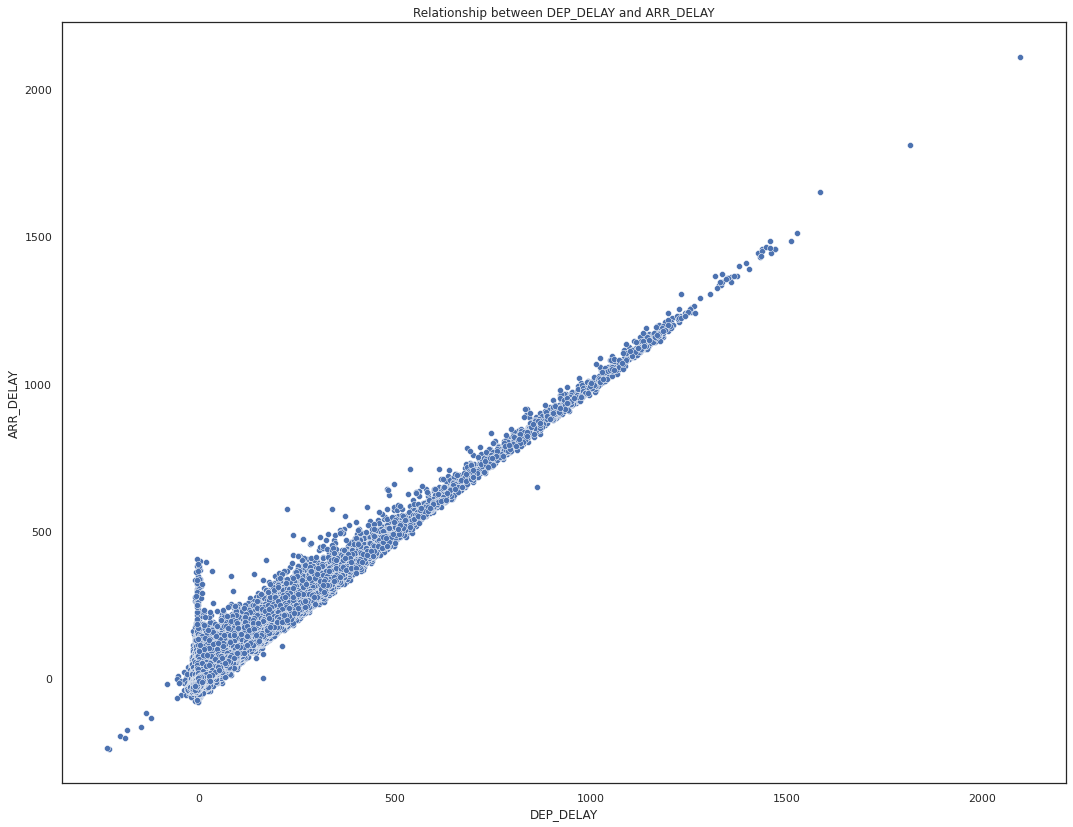

In [48]:
ax = sns.scatterplot(x='DEP_DELAY', y='ARR_DELAY', data=df)
ax.set_title("Relationship between DEP_DELAY and ARR_DELAY")
plt.show()

## Time of the day

In [49]:
df['ARR_TIME_'] = round(df['ARR_TIME']/100)
df['DEP_TIME_'] = round(df['DEP_TIME']/100)

In [50]:
dep_delay = df.loc[df.FLIGHT == 'DEPARTURE', ['FL_DATE','DEP_TIME_','DEP_DELAY']]
arr_delay = df.loc[df.FLIGHT == 'ARRIVAL', ['FL_DATE','ARR_TIME_','ARR_DELAY']]

arr_delay = arr_delay.groupby(['ARR_TIME_'])['ARR_DELAY'].describe().reset_index()
arr_delay.columns = arr_delay.columns + '_ARR'
arr_delay.rename(columns={"ARR_TIME__ARR": "TIME"}, inplace=True)

dep_delay = dep_delay.groupby(['DEP_TIME_'])['DEP_DELAY'].describe().reset_index()
dep_delay.columns = dep_delay.columns + '_DEP'
dep_delay.rename(columns={"DEP_TIME__DEP": "TIME"}, inplace=True)

arr_dep_delay = pd.merge(arr_delay, dep_delay, on=['TIME'], how='outer')
arr_dep_delay.head(20)

,TIME,count_ARR,mean_ARR,std_ARR,min_ARR,25%_ARR,50%_ARR,75%_ARR,max_ARR,count_DEP,mean_DEP,std_DEP,min_DEP,25%_DEP,50%_DEP,75%_DEP,max_DEP
0,0.0,8099.0,58.264971,106.982024,-39.0,-6.00,17.0,83.00,1006.0,3610.0,113.114404,81.283129,-6.0,52.00,101.0,145.0,757.0
1,1.0,3324.0,126.718712,144.158845,-35.0,29.00,83.0,192.00,2108.0,1503.0,180.147705,79.408596,-4.0,128.00,169.0,215.0,667.0
2,2.0,1154.0,224.266031,157.528712,-25.0,120.00,185.5,290.00,1093.0,544.0,249.854779,98.471519,-6.0,193.75,229.5,281.5,1225.0
3,3.0,446.0,299.127803,179.845787,-43.0,188.25,259.0,354.75,1169.0,197.0,295.573604,74.534617,190.0,254.00,283.0,326.0,659.0
4,4.0,1193.0,31.238894,149.384315,-65.0,-25.00,-17.0,-9.00,1150.0,52.0,357.865385,102.523078,40.0,309.00,340.5,385.0,792.0
5,5.0,5206.0,-4.500768,48.553520,-53.0,-18.00,-10.0,-1.00,1013.0,3609.0,5.220283,68.046539,-31.0,-6.00,-4.0,-1.0,874.0
6,6.0,17648.0,-7.276632,21.001285,-79.0,-15.00,-9.0,-3.00,923.0,19078.0,5.634081,65.558069,-234.0,-5.00,-3.0,0.0,1144.0
7,7.0,58638.0,-8.726491,18.397786,-55.0,-16.00,-10.0,-4.00,1155.0,34728.0,3.292847,51.491934,-20.0,-4.00,-2.0,0.0,1161.0
8,8.0,86535.0,-9.108430,23.244668,-63.0,-17.00,-11.0,-4.00,1366.0,73686.0,1.625587,38.208791,-32.0,-4.00,-2.0,0.0,1223.0
9,9.0,86044.0,-2.496339,32.540764,-50.0,-14.00,-7.0,3.00,1409.0,78532.0,2.300871,31.140674,-55.0,-4.00,-2.0,0.0,1435.0


In [51]:
arr_delay = df.loc[df.FLIGHT == 'ARRIVAL', ['FL_DATE','ARR_TIME_','ARR_DELAY']]
arr_delay = arr_delay.groupby(['ARR_TIME_'])['ARR_DELAY'].describe().reset_index()
arr_delay.rename(columns={"ARR_TIME_": "TIME"}, inplace=True)
arr_delay

,TIME,count,mean,std,min,25%,50%,75%,max
0,0.0,8099.0,58.264971,106.982024,-39.0,-6.00,17.0,83.00,1006.0
1,1.0,3324.0,126.718712,144.158845,-35.0,29.00,83.0,192.00,2108.0
2,2.0,1154.0,224.266031,157.528712,-25.0,120.00,185.5,290.00,1093.0
3,3.0,446.0,299.127803,179.845787,-43.0,188.25,259.0,354.75,1169.0
4,4.0,1193.0,31.238894,149.384315,-65.0,-25.00,-17.0,-9.00,1150.0
5,5.0,5206.0,-4.500768,48.553520,-53.0,-18.00,-10.0,-1.00,1013.0
6,6.0,17648.0,-7.276632,21.001285,-79.0,-15.00,-9.0,-3.00,923.0
7,7.0,58638.0,-8.726491,18.397786,-55.0,-16.00,-10.0,-4.00,1155.0
8,8.0,86535.0,-9.108430,23.244668,-63.0,-17.00,-11.0,-4.00,1366.0
9,9.0,86044.0,-2.496339,32.540764,-50.0,-14.00,-7.0,3.00,1409.0


In [52]:
dep_delay = df.loc[df.FLIGHT == 'DEPARTURE', ['FL_DATE','DEP_TIME_','DEP_DELAY']]
dep_delay = dep_delay.groupby(['DEP_TIME_'])['DEP_DELAY'].describe().reset_index()
dep_delay.rename(columns={"DEP_TIME_": "TIME"}, inplace=True)
dep_delay

,TIME,count,mean,std,min,25%,50%,75%,max
0,0.0,3610.0,113.114404,81.283129,-6.0,52.00,101.0,145.0,757.0
1,1.0,1503.0,180.147705,79.408596,-4.0,128.00,169.0,215.0,667.0
2,2.0,544.0,249.854779,98.471519,-6.0,193.75,229.5,281.5,1225.0
3,3.0,197.0,295.573604,74.534617,190.0,254.00,283.0,326.0,659.0
4,4.0,52.0,357.865385,102.523078,40.0,309.00,340.5,385.0,792.0
5,5.0,3609.0,5.220283,68.046539,-31.0,-6.00,-4.0,-1.0,874.0
6,6.0,19078.0,5.634081,65.558069,-234.0,-5.00,-3.0,0.0,1144.0
7,7.0,34728.0,3.292847,51.491934,-20.0,-4.00,-2.0,0.0,1161.0
8,8.0,73686.0,1.625587,38.208791,-32.0,-4.00,-2.0,0.0,1223.0
9,9.0,78532.0,2.300871,31.140674,-55.0,-4.00,-2.0,0.0,1435.0


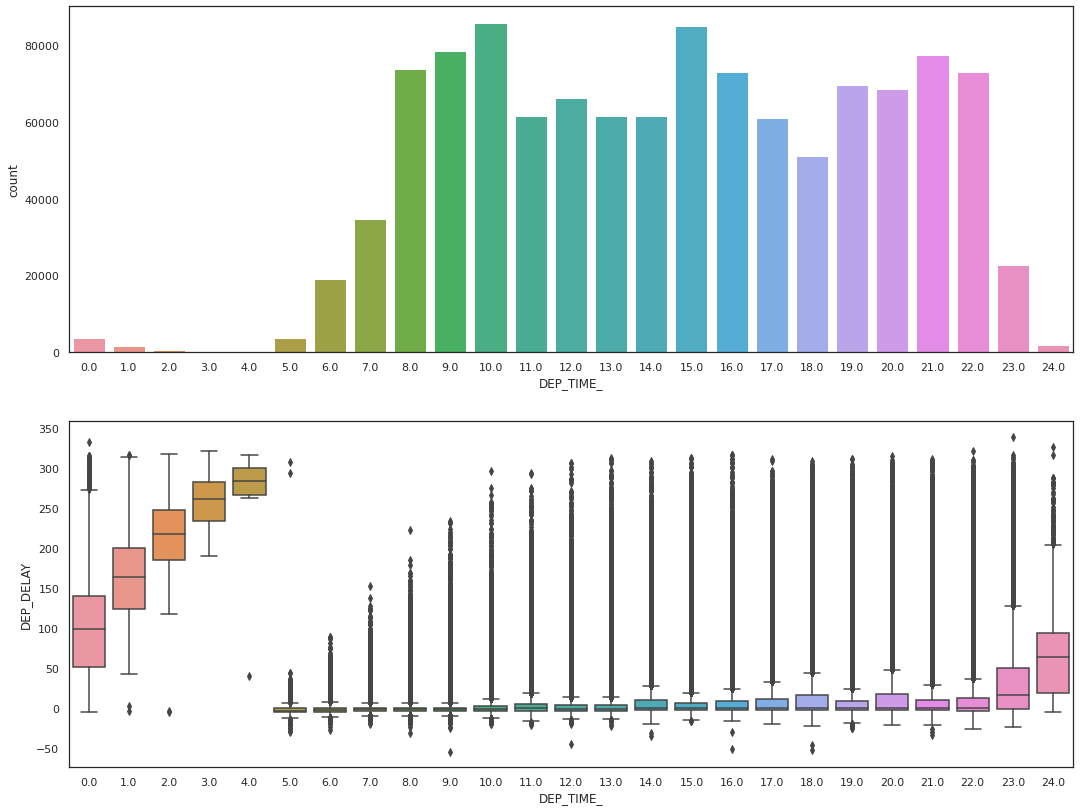

In [53]:
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df.loc[df.FLIGHT == 'DEPARTURE'], x='DEP_TIME_', ax=ax1)
sns.boxplot(data=df.loc[(df.FLIGHT == 'DEPARTURE') & (df.ARR_DELAY > -100) & (df.ARR_DELAY < 300)], x='DEP_TIME_', y='DEP_DELAY', ax=ax2)

plt.show()

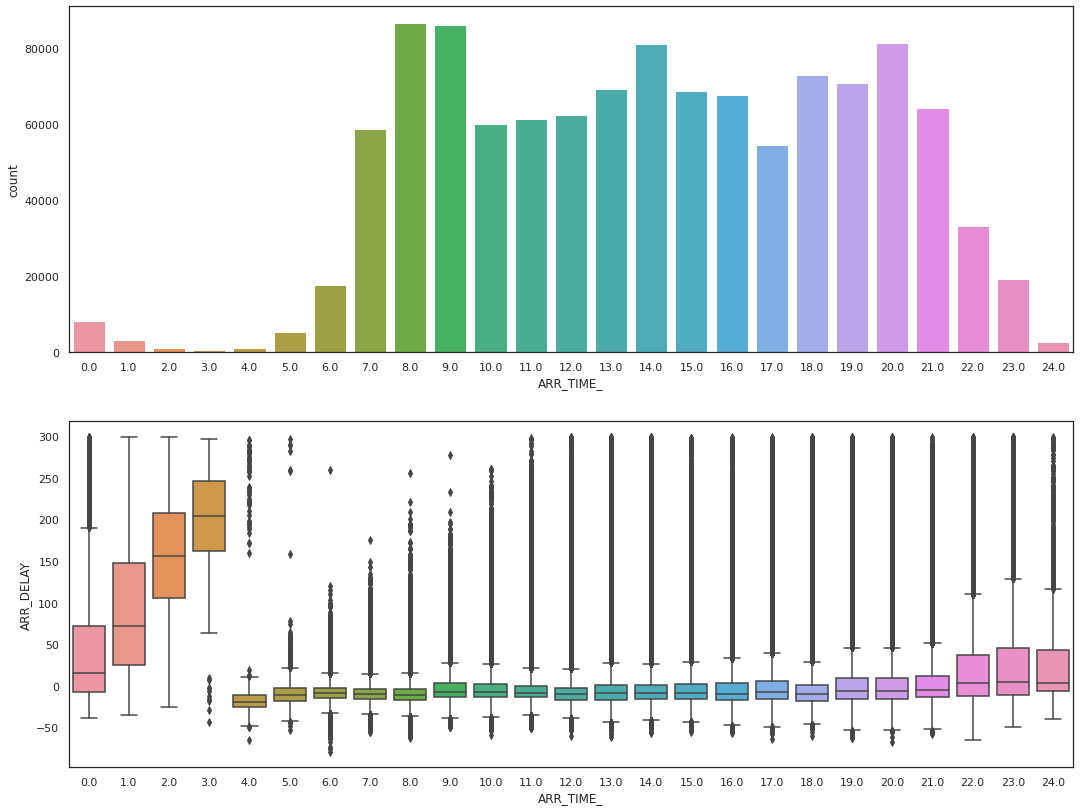

In [54]:
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df.loc[df.FLIGHT == 'ARRIVAL'], x='ARR_TIME_', ax=ax1)
sns.boxplot(data=df.loc[(df.FLIGHT == 'ARRIVAL') & (df.ARR_DELAY > -100) & (df.ARR_DELAY < 300)], x='ARR_TIME_', y='ARR_DELAY', ax=ax2)

plt.show()

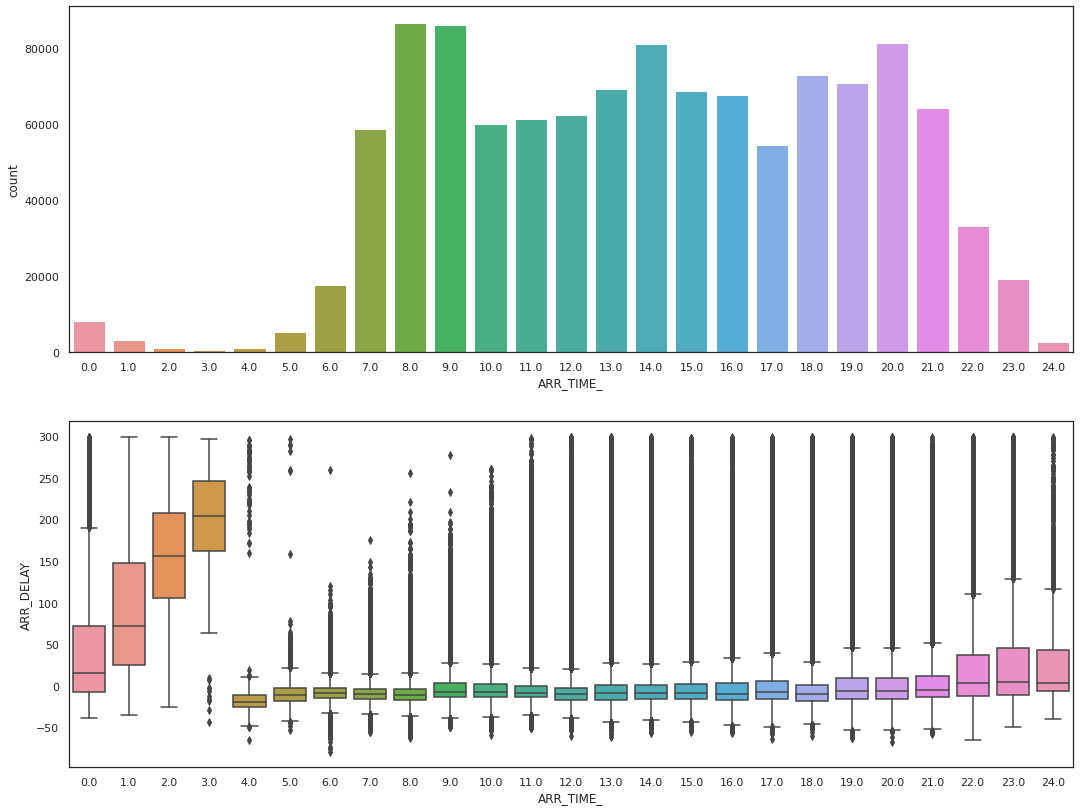

In [55]:
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df.loc[df.FLIGHT == 'ARRIVAL'], x='ARR_TIME_', ax=ax1)
sns.boxplot(data=df.loc[(df.FLIGHT == 'ARRIVAL') & (df.ARR_DELAY > -100) & (df.ARR_DELAY < 300)], x='ARR_TIME_', y='ARR_DELAY', ax=ax2)

plt.show()

# Atlanta airport arrivals

In [56]:
df.shape

(2271836, 41)

In [57]:
df = df[(df.DEST_AIRPORT_ID == AIRPORT)]

In [58]:
df.shape

(1135936, 41)

# Delay

In [59]:
df['DELAY_type'] = '1- Early (15 min or more before)'
df.loc[(df.ARR_DELAY >= -15), 'DELAY_type'] = '2- On time (Between 15 min before and 15 min late)'
df.loc[(df.ARR_DELAY >= 15), 'DELAY_type'] = '3- Late (Between 30 min and 60 min late)'
df.loc[(df.ARR_DELAY >= 60), 'DELAY_type'] = '4- Late (Between 60 min and 120 min late)'
df.loc[(df.ARR_DELAY >= 120), 'DELAY_type'] = '5- Late (Between 120 min and 300 min late)'
df.loc[(df.ARR_DELAY >= 300), 'DELAY_type'] = '6- Late (More than 300 min late)'

df['DELAY_type'].value_counts(normalize=True)*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2- On time (Between 15 min before and 15 min late)    60.140976
1- Early (15 min or more before)                      25.215065
3- Late (Between 30 min and 60 min late)               9.736112
4- Late (Between 60 min and 120 min late)              2.757990
5- Late (Between 120 min and 300 min late)             1.746225
6- Late (More than 300 min late)                       0.403632
Name: DELAY_type, dtype: float64

# Outliers

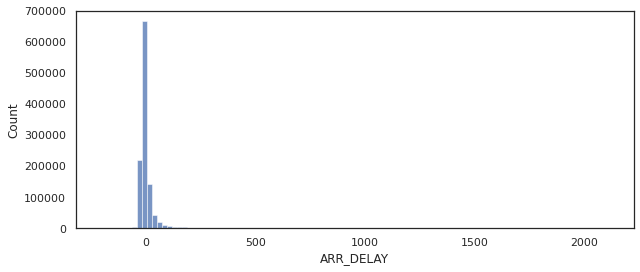

In [60]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

sns.histplot(data=df, x='ARR_DELAY', bins=100)
plt.show()

In [61]:
perc =[0.005, 0.01, 0.02, 0.05, .10, .25, 0.5, 0.75, .90, 0.95, 0.97, 0.99, 0.995]
df['ARR_DELAY'].describe(percentiles=perc).astype(int)

count    1135936
mean           1
std           47
min         -202
0.5%         -37
1%           -34
2%           -31
5%           -26
10%          -22
25%          -16
50%           -8
75%            3
90%           26
95%           58
97%           93
99%          193
99.5%        271
max         2108
Name: ARR_DELAY, dtype: int64

In [62]:
print(df.shape)
print(df.loc[(df.ARR_DELAY >= -35) & (df.ARR_DELAY <= 150)].shape)

if False:
    # DROP OUTLIERS
    df = df.loc[(df.ARR_DELAY >= -35) & (df.ARR_DELAY <= 150)]
else:
    # CLIP OUTLIERS
    df['ARR_DELAY'] = np.clip(df.ARR_DELAY, -35, 150)

(1135936, 42)
(1110432, 42)


In [63]:
1110432/1135936*100

97.75480308749789

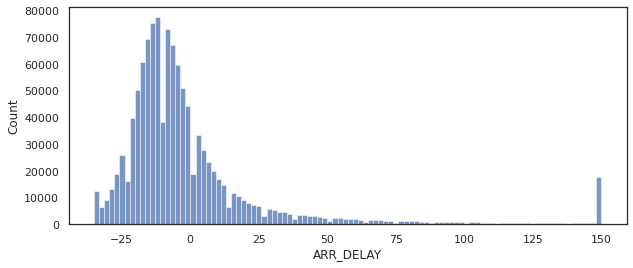

In [64]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

sns.histplot(data=df, x='ARR_DELAY', bins=100)
plt.show()

# Origin

In [65]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
g = df.groupby('ORIGIN')['ARR_DELAY'].describe(include = np.number, percentiles = perc)
g.sort_values('count', ascending=False).head(20)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
ORIGIN,,,,,,,,,,,,
MCO,27438.0,1.763904,29.512890,-35.0,-22.0,-18.0,-13.0,-6.0,4.0,28.0,60.0,150.0
LGA,27008.0,1.377444,37.857171,-35.0,-35.0,-30.0,-21.0,-9.0,8.0,44.0,88.0,150.0
FLL,24910.0,3.122120,30.983148,-35.0,-22.0,-19.0,-13.0,-6.0,5.0,33.0,68.0,150.0
ORD,22348.0,4.913639,36.031457,-35.0,-26.0,-22.0,-15.0,-7.0,10.0,45.0,86.0,150.0
TPA,21261.0,1.785335,27.707996,-35.0,-19.0,-17.0,-12.0,-6.0,4.0,25.0,53.0,150.0
DFW,20287.0,4.382018,31.436232,-35.0,-21.0,-18.0,-12.0,-5.0,7.0,36.0,69.0,150.0
BWI,19912.0,1.269536,30.901739,-35.0,-24.0,-21.0,-15.0,-7.0,5.0,29.0,61.0,150.0
BOS,19535.0,2.521065,34.346847,-35.0,-30.0,-25.0,-17.0,-7.0,8.0,37.0,76.3,150.0
PHL,19454.0,-0.422741,32.935802,-35.0,-30.0,-26.0,-19.0,-9.0,5.0,32.0,68.0,150.0


In [66]:
g = df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].describe(include = np.number, percentiles = perc)
g.sort_values('count', ascending=False).head(20)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
OP_UNIQUE_CARRIER,,,,,,,,,,,,
DL,725547.0,-1.967998,28.508517,-35.0,-26.0,-22.0,-16.0,-9.0,1.00,20.0,47.00,150.0
WN,121455.0,2.505759,28.275469,-35.0,-23.0,-19.0,-13.0,-5.0,7.00,30.0,57.00,150.0
9E,66272.0,0.589193,34.511535,-35.0,-27.0,-24.0,-17.0,-10.0,3.00,33.0,76.00,150.0
OO,65095.0,5.697688,37.116663,-35.0,-24.0,-21.0,-14.0,-6.0,8.00,47.0,96.00,150.0
EV,45173.0,2.986186,37.519247,-35.0,-27.0,-23.0,-17.0,-9.0,4.00,43.0,95.00,150.0
AA,35744.0,5.632442,32.434942,-35.0,-23.0,-19.0,-13.0,-4.0,11.00,42.0,74.00,150.0
NK,24405.0,4.063471,33.589651,-35.0,-24.0,-20.0,-14.0,-6.0,8.00,40.0,77.00,150.0
UA,13673.0,1.948146,33.721331,-35.0,-28.0,-24.0,-17.0,-8.0,7.00,38.0,74.00,150.0
YX,10739.0,1.862371,31.864204,-35.0,-28.0,-24.0,-16.0,-7.0,7.00,37.0,68.00,150.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


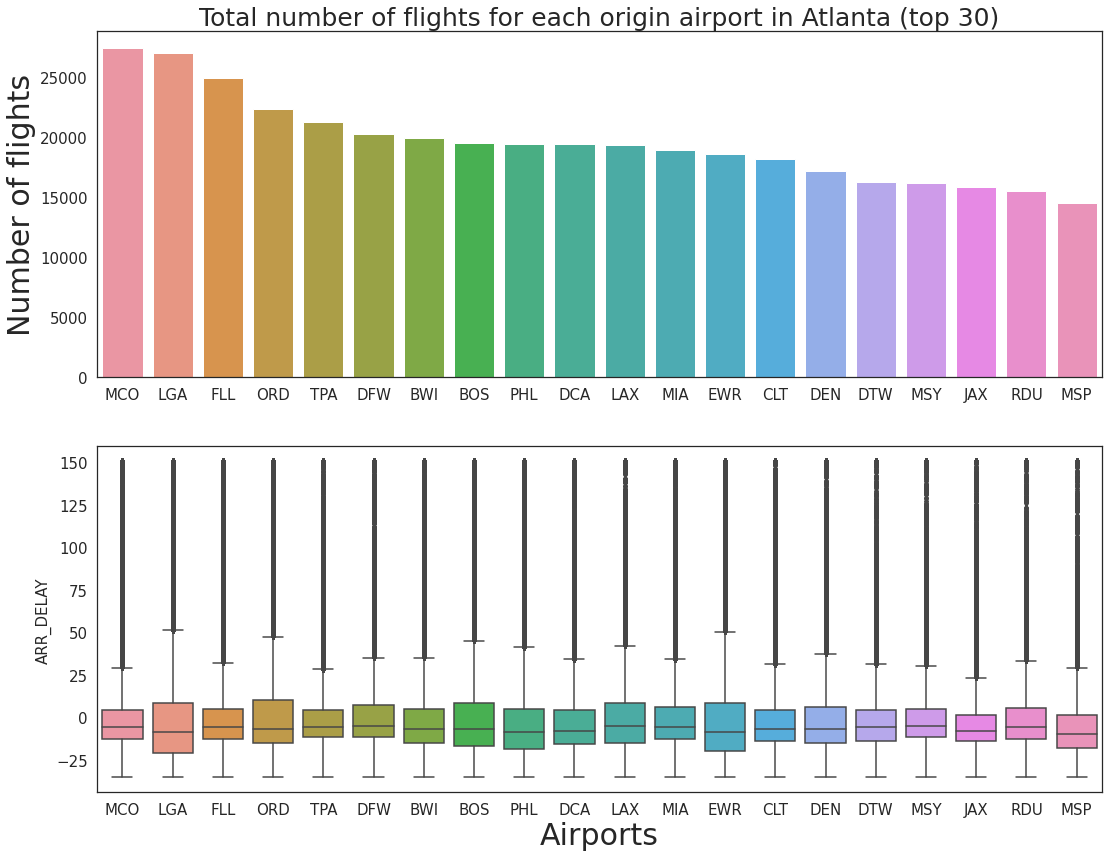

In [67]:
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

origin_vc = df['ORIGIN'].value_counts().to_frame()
origin_vc = origin_vc.sort_values('ORIGIN',ascending=False)
origin_vc.reset_index(inplace=True)
origin_vc['index'] = origin_vc['index'].astype('string')
origin_vc = origin_vc.head(20)

sns.barplot(x="index", y="ORIGIN", data=origin_vc, ax=ax1)
ax1.axes.set_title("Total number of flights for each origin airport in Atlanta (top 30)",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=30)
ax1.tick_params(labelsize=15)

origin_map = {k:v for k,v in zip(origin_vc['index'], range(len(origin_vc.index)))}

origin_delay = df[df.ORIGIN.isin(origin_vc['index'].to_list())]
origin_delay['ORIGIN'] = origin_delay['ORIGIN'].astype('string')
origin_delay['idx'] =  origin_delay['ORIGIN'].map(origin_map)
origin_delay = origin_delay.sort_values('idx')

sns.boxplot(x="ORIGIN", y="ARR_DELAY", data=origin_delay, ax=ax2)
ax2.set_xlabel("Airports",fontsize=30)
ax2.set_ylabel("ARR_DELAY",fontsize=15)
ax2.tick_params(labelsize=15)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


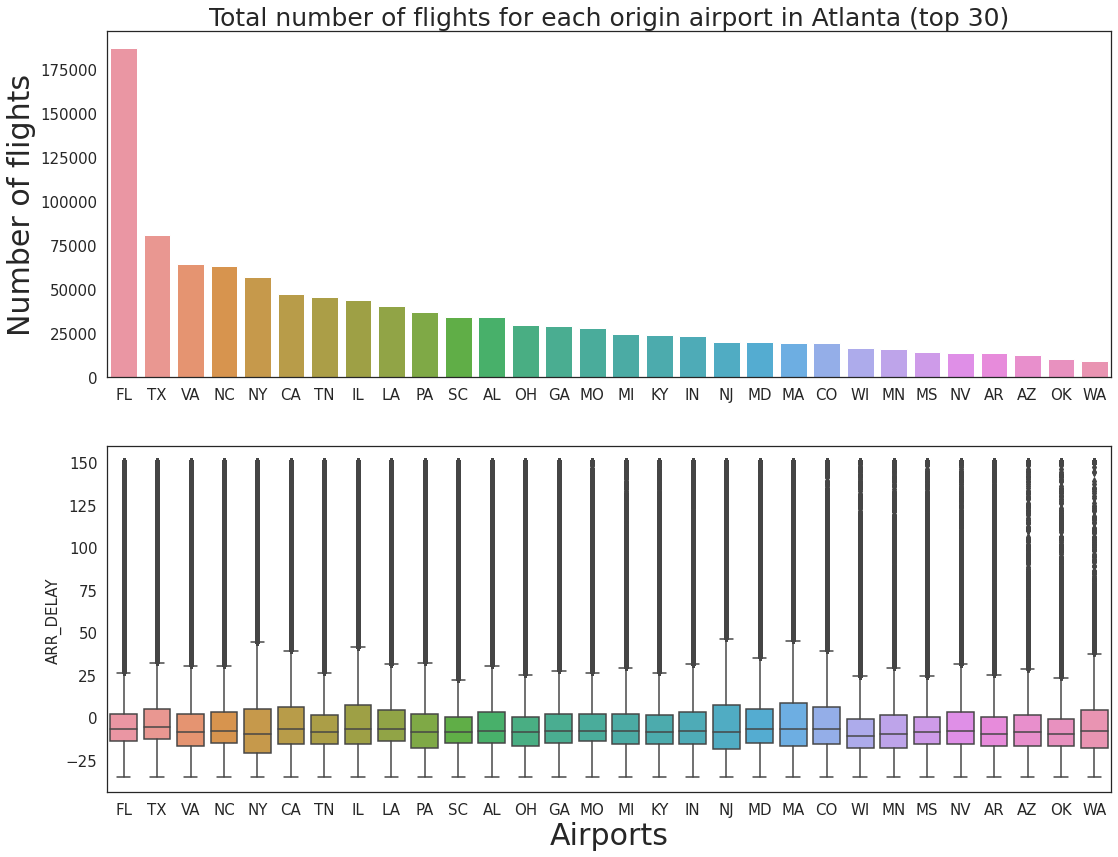

In [68]:
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

origin_vc = df['ORIGIN_STATE_ABR'].value_counts().to_frame()
origin_vc = origin_vc.sort_values('ORIGIN_STATE_ABR',ascending=False)
origin_vc.reset_index(inplace=True)
origin_vc['index'] = origin_vc['index'].astype('string')
origin_vc = origin_vc.head(30)

sns.barplot(x="index", y="ORIGIN_STATE_ABR", data=origin_vc, ax=ax1)
ax1.axes.set_title("Total number of flights for each origin airport in Atlanta (top 30)",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=30)
ax1.tick_params(labelsize=15)

origin_map = {k:v for k,v in zip(origin_vc['index'], range(len(origin_vc.index)))}

origin_delay = df[df.ORIGIN_STATE_ABR.isin(origin_vc['index'].to_list())]
origin_delay['ORIGIN_STATE_ABR'] = origin_delay['ORIGIN_STATE_ABR'].astype('string')
origin_delay['idx'] =  origin_delay['ORIGIN_STATE_ABR'].map(origin_map)
origin_delay = origin_delay.sort_values('idx')

sns.boxplot(x="ORIGIN_STATE_ABR", y="ARR_DELAY", data=origin_delay, ax=ax2)
ax2.set_xlabel("Airports",fontsize=30)
ax2.set_ylabel("ARR_DELAY",fontsize=15)
ax2.tick_params(labelsize=15)

plt.show()

### Carrier

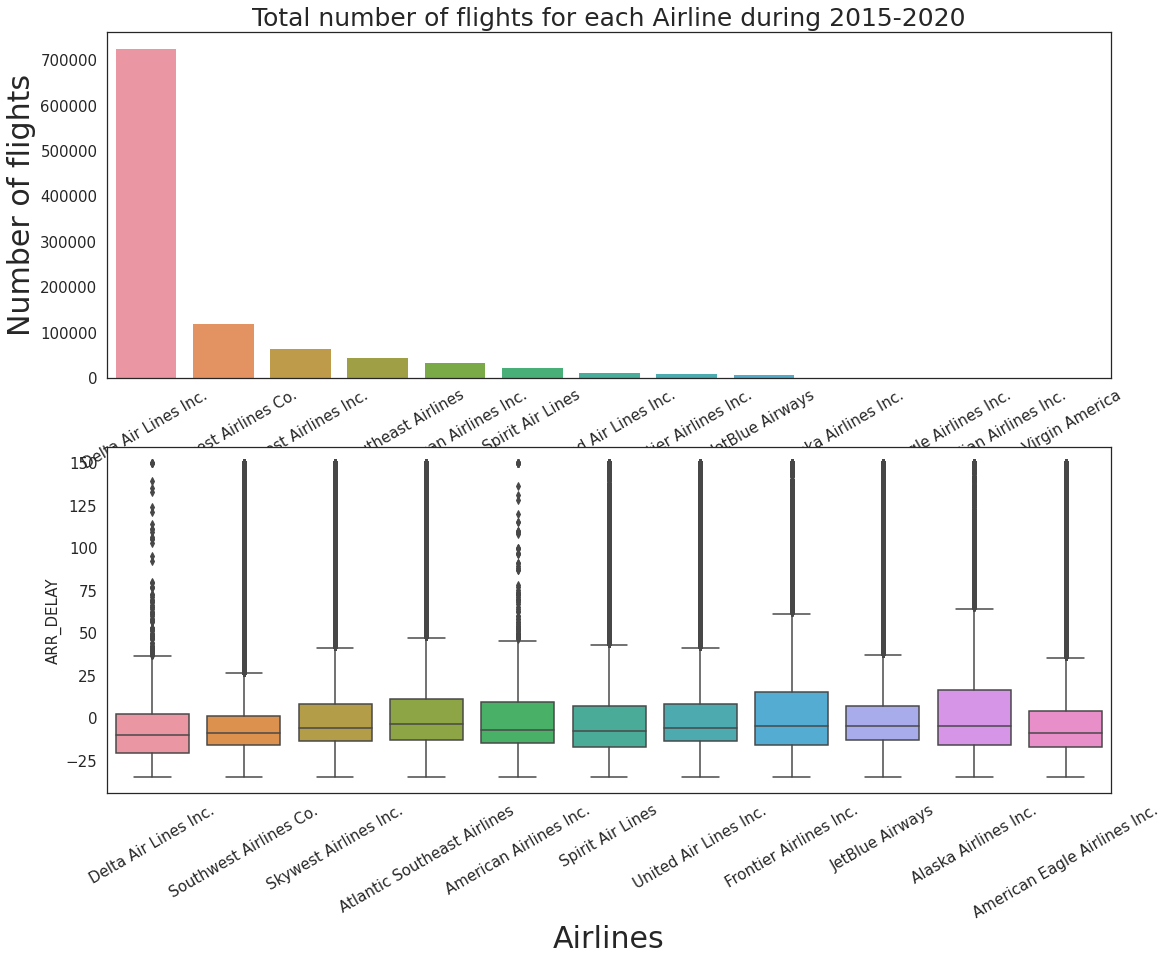

In [90]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

airlines = pd.read_csv(os.path.join(DIR, 'airlines_airports', 'airlines.csv'))

fig, (ax1, ax2) = plt.subplots(nrows=2)

carrier_vc = df['OP_UNIQUE_CARRIER'].value_counts().to_frame()
carrier_vc = carrier_vc.sort_values('OP_UNIQUE_CARRIER',ascending=False)
carrier_vc.reset_index(inplace=True)
carrier_vc['index'] = carrier_vc['index'].astype('string')
carrier_vc = carrier_vc.head(30)

carrier_vc = pd.merge(carrier_vc, airlines, how='left', left_on='index', right_on='IATA_CODE')

sns.barplot(x="AIRLINE", y="OP_UNIQUE_CARRIER", data=carrier_vc, ax=ax1)
ax1.axes.set_title("Total number of flights for each Airline during 2015-2020",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=30)
ax1.tick_params(labelsize=15)
ax1.set_xticklabels(ax.get_xticklabels(),rotation = 30)

carrier_map = {k:v for k,v in zip(carrier_vc['index'], range(len(carrier_vc.index)))}

carrier_delay = df[df.OP_UNIQUE_CARRIER.isin(carrier_vc['index'].to_list())]
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')
carrier_delay['idx'] =  carrier_delay['DEST'].map(dest_map)
carrier_delay = carrier_delay.sort_values('idx')

carrier_delay = pd.merge(carrier_delay, airlines, how='left', left_on='OP_UNIQUE_CARRIER', right_on='IATA_CODE')

sns.boxplot(x="AIRLINE", y="ARR_DELAY", data=carrier_delay, ax=ax2)
ax2.set_xlabel("Airlines",fontsize=30)
ax2.set_ylabel("ARR_DELAY",fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_xticklabels(ax.get_xticklabels(),rotation = 30)

plt.show()

## Weekday

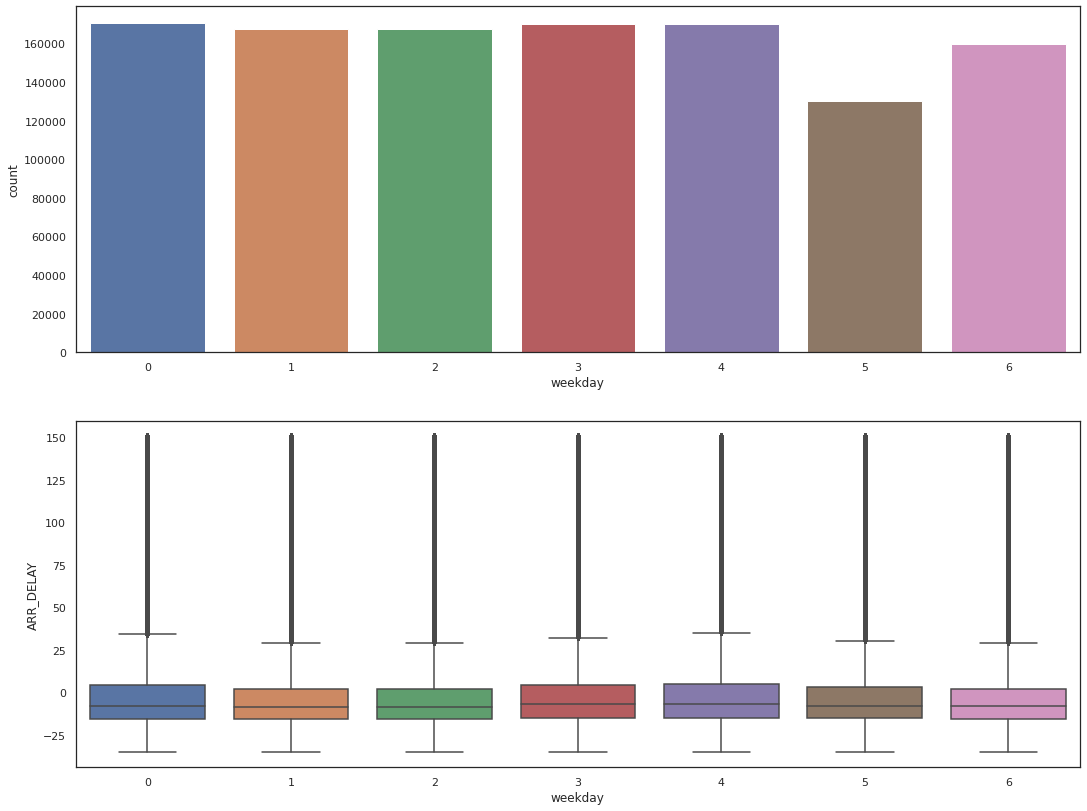

In [70]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df.loc[df.FLIGHT == 'ARRIVAL'], x='weekday', ax=ax1)
sns.boxplot(data=df.loc[(df.FLIGHT == 'ARRIVAL') & (df.ARR_DELAY > -100) & (df.ARR_DELAY < 300)], x="weekday", y='ARR_DELAY', ax=ax2)

plt.show()

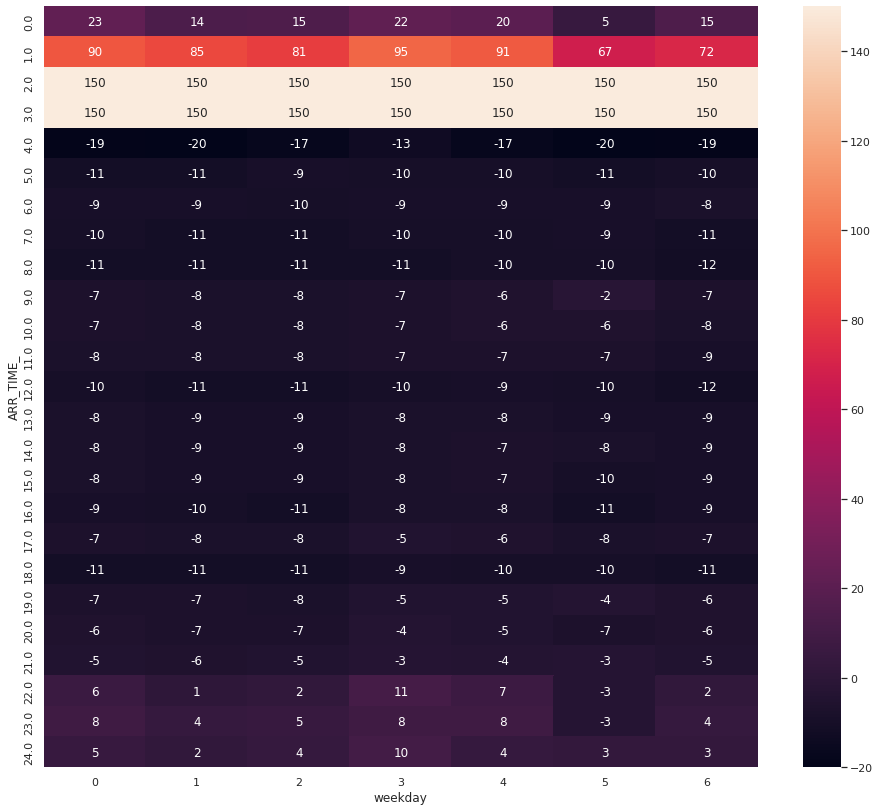

In [71]:
plt.figure(figsize=(16,14))
pt = pd.pivot_table(df, values='ARR_DELAY', index='ARR_TIME_', columns='weekday', aggfunc='median')
sns.heatmap(pt, annot=True, fmt='.0f')
plt.show()

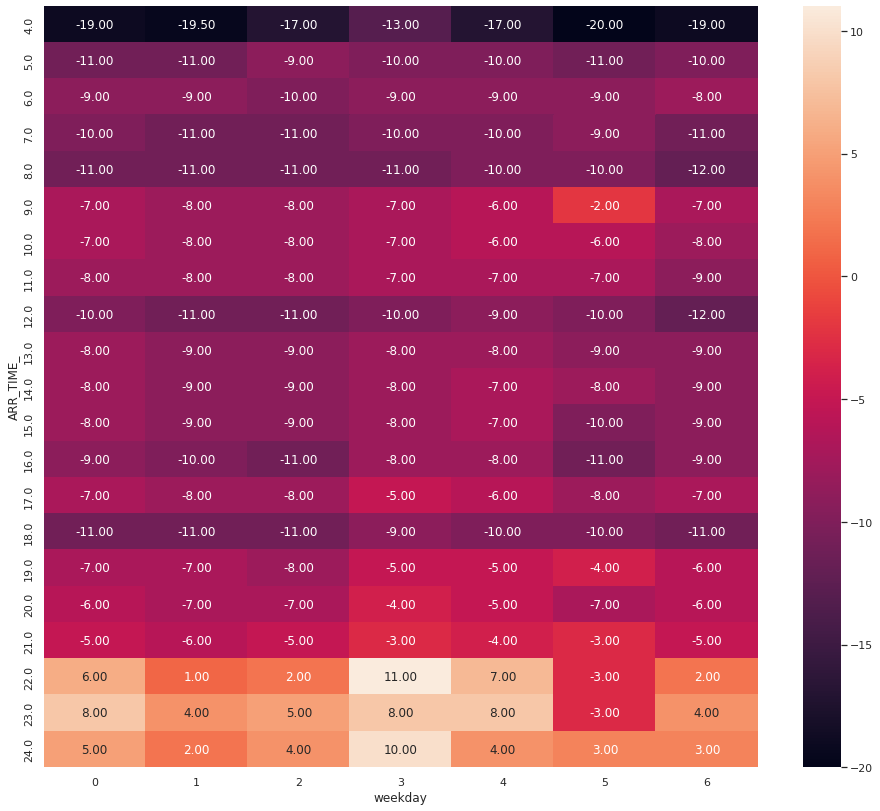

In [72]:
plt.figure(figsize=(16,14))
pt = pd.pivot_table(df.loc[df.ARR_TIME_ >= 4], values='ARR_DELAY', index='ARR_TIME_', columns='weekday', aggfunc='median')
sns.heatmap(pt, annot=True, fmt='.2f')
plt.show()

In [ ]:
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df, x='ARR_TIME_', ax=ax1)
sns.boxplot(data=df, x='ARR_TIME_', y='ARR_DELAY', ax=ax2)

plt.show()

# Month

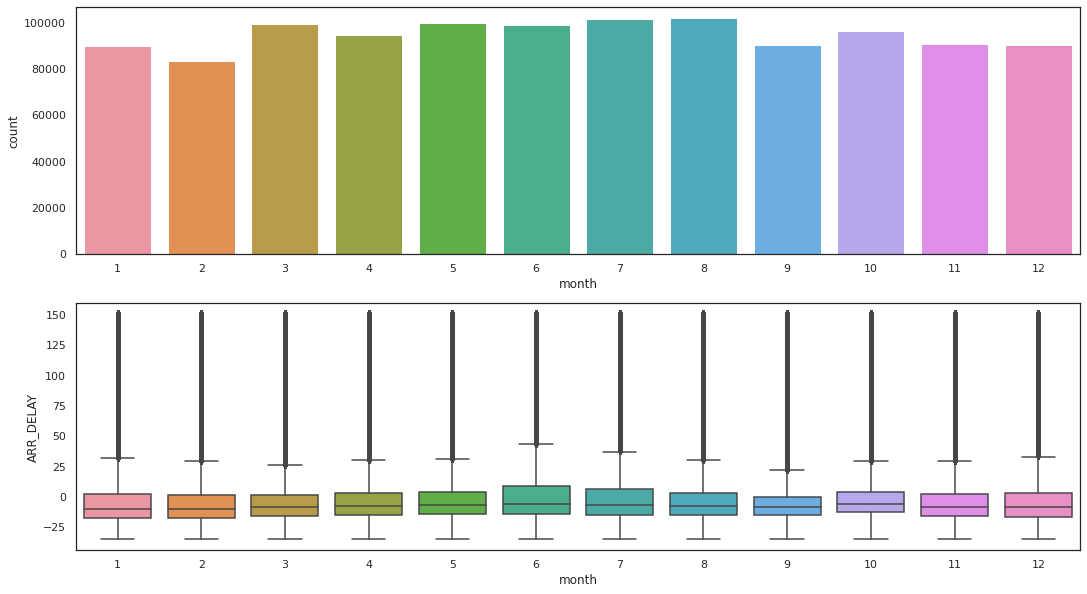

In [73]:
rcParams['figure.figsize'] = 18,10

sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df, x='month', ax=ax1)
sns.boxplot(data=df[(df.ARR_DELAY > -100) & (df.ARR_DELAY < 300)], x='month', y='ARR_DELAY', ax=ax2)

plt.show()

### Number of flights in a day

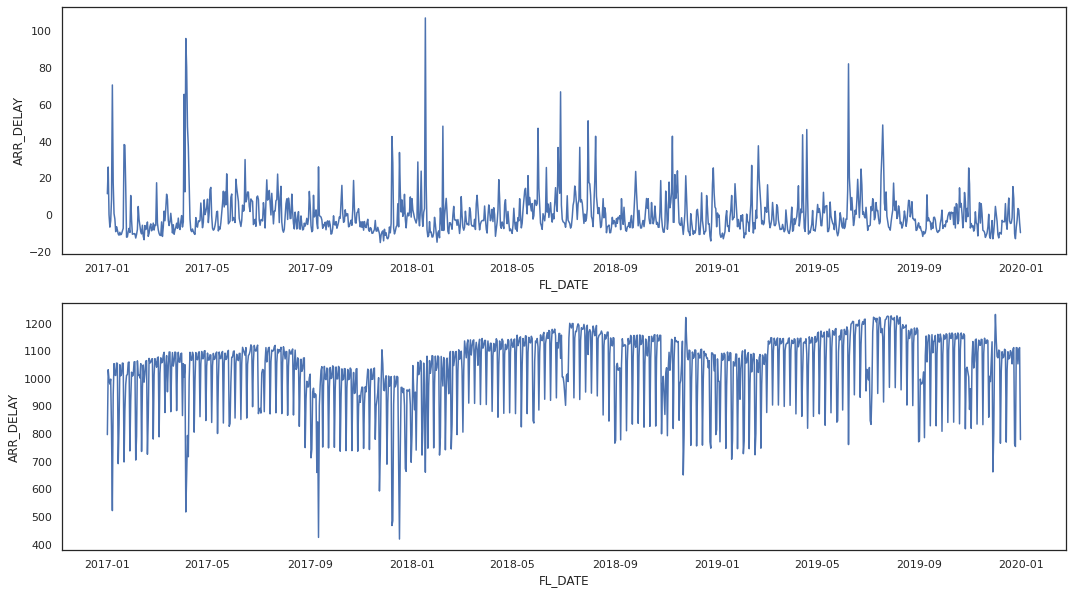

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.lineplot(data=df.groupby('FL_DATE')[['ARR_DELAY']].mean().reset_index(), x='FL_DATE', y='ARR_DELAY', ax=ax1) 
sns.lineplot(data=df.groupby('FL_DATE')[['ARR_DELAY']].count().reset_index(), x='FL_DATE', y='ARR_DELAY', ax=ax2)

plt.show()

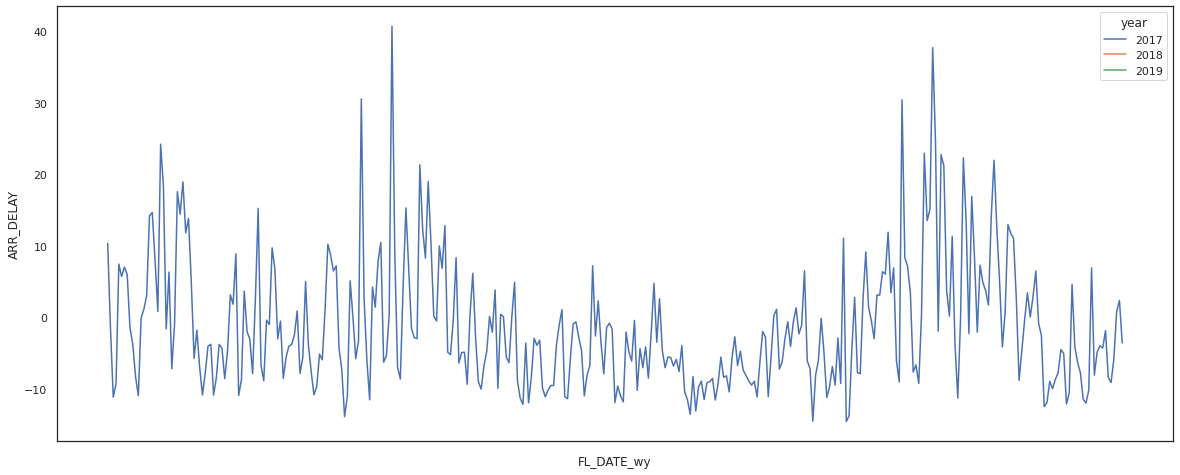

In [75]:
rcParams['figure.figsize'] = 20,8

sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, ax = plt.subplots()

df['year'] = df['year'].astype('category')
df['FL_DATE_wy'] = df['FL_DATE'].dt.strftime('%m%d')
ax = sns.lineplot(data=df[(df.ARR_DELAY > -200) & (df.ARR_DELAY < 500)].groupby(['FL_DATE_wy','year'])[['ARR_DELAY']].mean().reset_index(), x='FL_DATE_wy', y='ARR_DELAY', hue='year') 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 15)

plt.show()

In [76]:
del fig, ax

# DELAY types

In [77]:
carrier_imp = df['CARRIER_DELAY'] / df['ARR_DELAY'] * 100
weather_imp = df['WEATHER_DELAY'] / df['ARR_DELAY'] * 100
nas_imp = df['NAS_DELAY'] / df['ARR_DELAY'] * 100
late_aircraft_imp = df['LATE_AIRCRAFT_DELAY'] / df['ARR_DELAY'] * 100

In [78]:
type_delay = pd.concat( [carrier_imp.describe(), weather_imp.describe(), nas_imp.describe(), late_aircraft_imp.describe()], axis=1)
type_delay.columns = ['CARRIER_DELAY_pct', 'WEATHER_DELAY_pct', 'NAS_DELAY_pct', 'LATE_AIRCRAFT_DELAY_pct']
type_delay

,CARRIER_DELAY_pct,WEATHER_DELAY_pct,NAS_DELAY_pct,LATE_AIRCRAFT_DELAY_pct
count,166346.000000,166346.000000,166346.000000,166346.000000
mean,31.049181,4.547136,33.523247,39.820814
std,59.291543,25.727028,44.278568,47.548374
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,6.000000,10.666667
75%,47.272727,0.000000,73.333333,86.440678
max,1206.666667,1398.666667,792.000000,890.666667


# For a given date, month, airline or origin

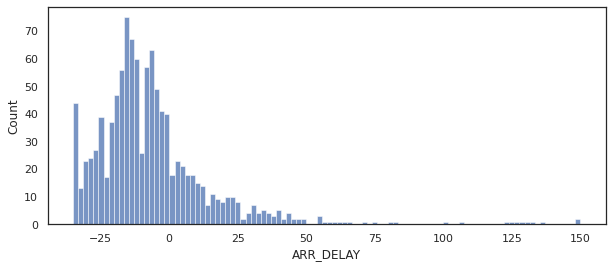

In [79]:
date_check = '2019-01-15'
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

sns.histplot(data=df[df.FL_DATE == date_check], x='ARR_DELAY', bins=100)
plt.show()

In [80]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'].astype('string'))
df['FL_DATE']

265        2017-01-01
268        2017-01-01
347        2017-01-01
349        2017-01-01
350        2017-01-01
              ...    
20309723   2019-12-31
20309919   2019-12-31
20309950   2019-12-31
20309974   2019-12-31
20310047   2019-12-31
Name: FL_DATE, Length: 1135936, dtype: datetime64[ns]

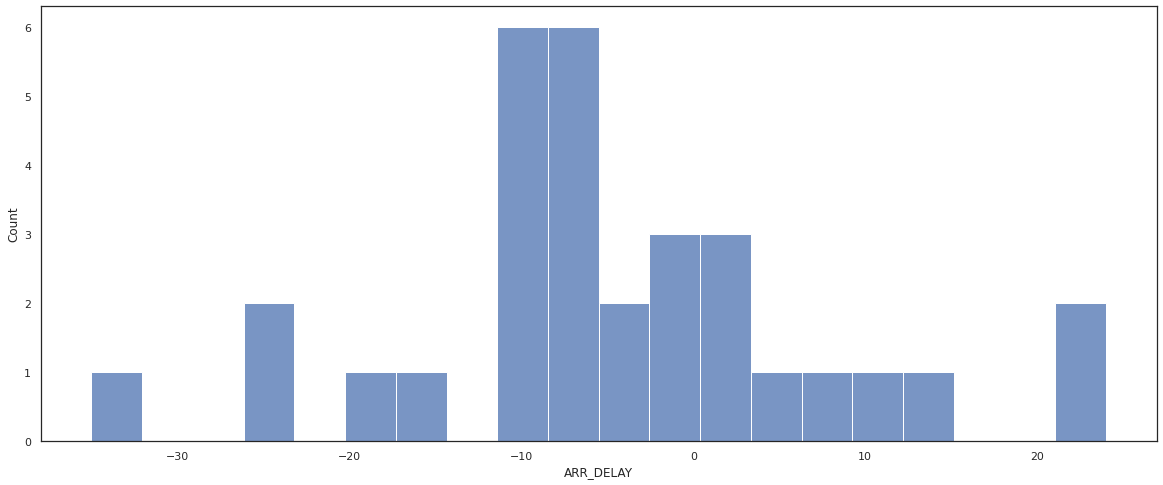

In [81]:
date_check = '2019-01-15'
carrier = 'AA'

sns.histplot(data=df[(df.FL_DATE == date_check) & (df.OP_UNIQUE_CARRIER == carrier)], x='ARR_DELAY', bins=20)
plt.show()

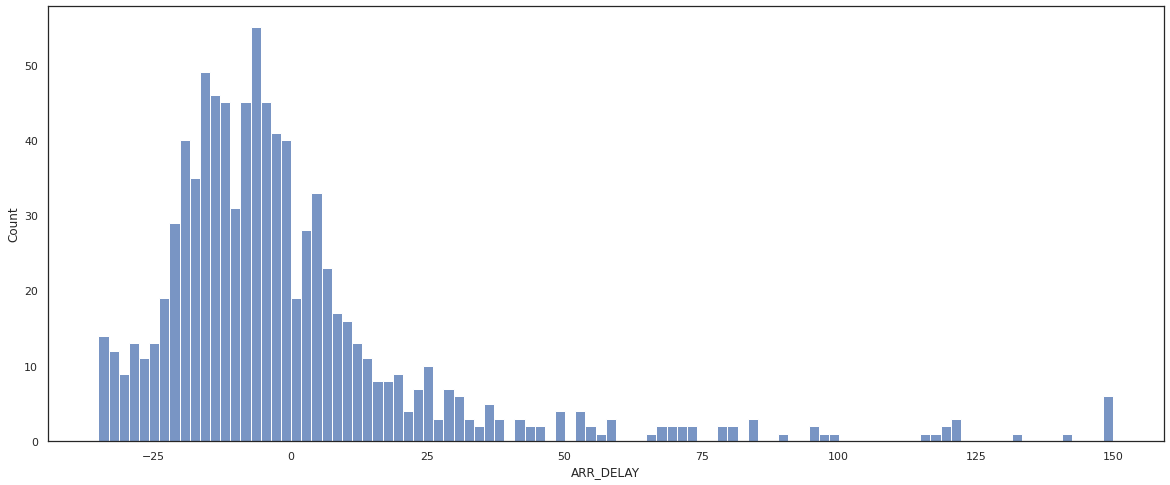

In [82]:
date_ini = '2018-02-28'
date_fin = '2018-03-28'
carrier = 'AA'

sns.histplot(data=df[(df.FL_DATE >= date_ini) & (df.FL_DATE <= date_fin) & (df.OP_UNIQUE_CARRIER == carrier)], x='ARR_DELAY', bins=100)
plt.show()

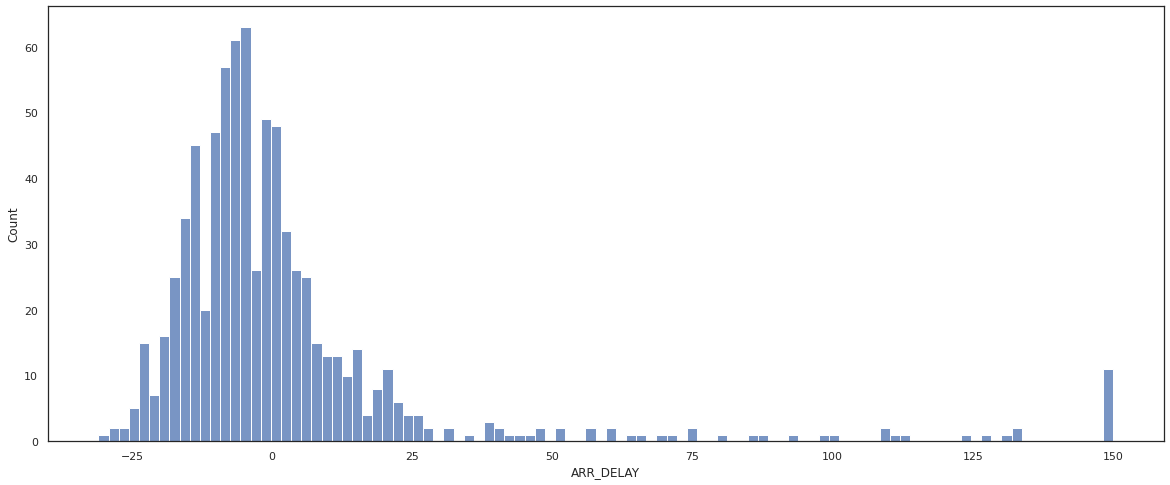

In [83]:
date_ini = '2018-02-28'
date_fin = '2018-03-28'
origin = 'MCO'

sns.histplot(data=df[(df.FL_DATE >= date_ini) & (df.FL_DATE <= date_fin) & (df.ORIGIN == origin)], x='ARR_DELAY', bins=100)
plt.show()

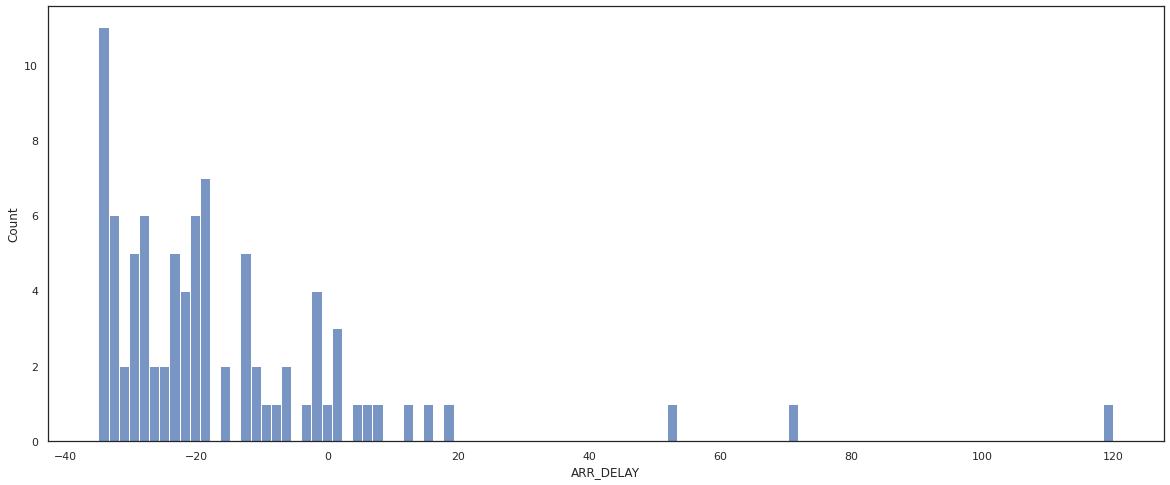

In [84]:
date_ini = '2018-02-28'
date_fin = '2018-03-28'
carrier = 'AA'
origin = 'LAX'

sns.histplot(data=df[(df.FL_DATE >= date_ini) & (df.FL_DATE <= date_fin) & (df.OP_UNIQUE_CARRIER == carrier) & (df.ORIGIN == origin)], x='ARR_DELAY', bins=100)
plt.show()

In [84]:
FINISH

In [85]:
sub.groupby(['DEP_TIME_'])['DEP_DELAY'].describe(include = np.number, percentiles = perc)

NameError: ignored

In [ ]:
date_ini = '2018-02-28'
date_fin = '2018-03-28'
origin = 'MCO'
sub = df[(df.FL_DATE >= date_ini) & (df.FL_DATE <= date_fin) & (df.OP_UNIQUE_CARRIER == 'AA')]
sub.groupby(['ARR_TIME_'])['ARR_DELAY'].describe(include = np.number, percentiles = perc)

In [ ]:
date_ini = '2018-03-21'
date_fin = '2018-03-28'
carrier = 'AA'
sub = df[(df.FL_DATE >= date_ini) & (df.FL_DATE <= date_fin) & (df.ORIGIN == origin)]
sub.groupby(['ARR_TIME_'])['ARR_DELAY'].describe(include = np.number, percentiles = perc)

In [ ]:
stop

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(20,6))

sns.histplot(data=df[(df.year==2019)&(df.month==12)], x="ARR_DELAY", hue="OP_UNIQUE_CARRIER")

In [ ]:

df['OP_CARRIER_AIRLINE_ID'].value_counts()

In [ ]:
df.shape

In [ ]:
stop

In [ ]:
# Add weather
WEATHER_DIR = os.path.join(DIR,'weather')
weather_df = pd.read_csv(os.path.join(WEATHER_DIR, 'weather.csv'))